In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
import csv


## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True, is_transcript=False, is_prot=False, delete_other=True):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("gene_name \"", expand=True)[1].str.split('\";', expand=True)[0]
        
        ## Get get transcript biotype
        df["gene_biotype"] = df["other"].str.split('gene_biotype "', expand=True)[1].str.split('"', expand=True)[0]
        
        ## If is transcript get transcript id and transcript biotype
        if is_transcript:
            df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]
            df["transcript_biotype"] = df["other"].str.split('transcript_biotype "', expand=True)[1].str.split('"', expand=True)[0]
            
            ## If is prot get protein_id
            if is_prot:
                df["protein_id"] = df["other"].str.split('protein_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["ccds_id"] = df["other"].str.split('ccds_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)
        

    else:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Get transcript ids
        df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]

        ## Get exon number
        df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        if delete_other:
            df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)

    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [3]:
## Open original reference
original_ref = pd.read_csv("../../article_analysis/references/Homo_sapiens.GRCh38.107_ERCC.gtf", header=None, delimiter="\t", low_memory=False, 
                       names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"], comment="#")

original_ref = original_ref.loc[~original_ref["chr"].str.startswith("ERCC-")]

## Parse through reference to get gene names and ids
orig_ref = original_ref.loc[original_ref["type"]=="gene"].copy()
orig_ref = parse_df_columns(orig_ref, is_ref=True)

In [4]:
## Import and parse through extended annotations
ref = pd.read_csv("../../article_analysis/data/raw/nextflow_pipeline_output/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

ref = ref.loc[~ref["chr"].str.startswith("ERCC-")]

ref = parse_df_columns(ref, is_ref=False)

ref_transcripts = ref.loc[ref["type"] == "transcript"].copy()

In [5]:
## Import data for transcript level counts and fix column names

df_cell_line = pd.read_csv("../data/combined_protein_unique_blast_filter.csv", 
                             low_memory=False, header=0)

df_brain = pd.read_csv("../data/combined_unique_protein_spectral_cnt_gt5 _blast_search.csv", 
                             low_memory=False, header=0)

In [6]:
## Create gene id and transcript id for proteins

df_cell_line["transcript_id"] = df_cell_line["Protein"].str.split("|", expand=True)[1].str.split("_", expand=True)[0].copy()
df_cell_line["gene_id"] = df_cell_line["Protein"].str.split("|", expand=True)[2].copy()
df_cell_line = df_cell_line[["gene_id", "transcript_id", "Protein", "Combined Unique Spectral Count"]].copy()
df_cell_line.columns = ["gene_id", "transcript_id", "protein_id", "combined_unique_spectral_count"]

df_brain["transcript_id"] = df_brain["Protein"].str.split("|", expand=True)[1].str.split("_", expand=True)[0].copy()
df_brain["gene_id"] = df_brain["Protein"].str.split("|", expand=True)[2].copy()
df_brain = df_brain[["gene_id", "transcript_id", "Protein", "Spectral Count"]].copy()
df_brain.columns = ["gene_id", "transcript_id", "protein_id", "combined_unique_spectral_count"]

In [7]:
## Add gene name to the protein results, also add transcript start, end, strand, and chromosome

df_cell_line = df_cell_line.merge(orig_ref[["gene_id", "gene_name"]], on="gene_id", how="left")
df_cell_line = df_cell_line.merge(ref_transcripts[["transcript_id", "chr", "start", "end", "strand"]],
                                  on="transcript_id", how="left")



df_brain = df_brain.merge(orig_ref[["gene_id", "gene_name"]], on="gene_id", how="left")
df_brain = df_brain.merge(ref_transcripts[["transcript_id", "chr", "start", "end", "strand"]],
                                  on="transcript_id", how="left")

In [8]:
## Display cell line results
df_cell_line

,gene_id,transcript_id,protein_id,combined_unique_spectral_count,gene_name,chr,start,end,strand
0,ENSG00000100142,BambuTx1188,db|BambuTx1188_1|ENSG00000100142,13,POLR2F,22,37953683.0,38041915.0,+
1,BambuGene73984,BambuTx2524,db|BambuTx2524_3|BambuGene73984,6,NaN,13,106782748.0,106786203.0,-


In [9]:
## Display brain results
df_brain

,gene_id,transcript_id,protein_id,combined_unique_spectral_count,gene_name,chr,start,end,strand
0,BambuGene202116,BambuTx1361,sp|BambuTx1361_2|BambuGene202116,10,NaN,4,52861143.0,52862181.0,-
1,ENSG00000069535,BambuTx1879,sp|BambuTx1879_1|ENSG00000069535,10,MAOB,X,43855661.0,43882419.0,-
2,ENSG00000108961,BambuTx703,sp|BambuTx703_3|ENSG00000108961,28,RANGRF,17,8289128.0,8290087.0,+


In [10]:
## Add source to data
df_cell_line["Source"] = "Cell line mass-spec data"

df_brain["Source"] = "Brain mass-spec data"

In [11]:
## Create final dataframe merging brain and cell-line data
final_df = pd.concat([df_cell_line, df_brain])

In [12]:
## Fill gene name with gene id when gene name is lacking
final_df['gene_name'].fillna(final_df['gene_id'], inplace=True)

In [13]:
final_df["ID"] = final_df["gene_name"] + "\n" + final_df["transcript_id"]

In [14]:
## Show final df
final_df

,gene_id,transcript_id,protein_id,combined_unique_spectral_count,gene_name,chr,start,end,strand,Source,ID
0,ENSG00000100142,BambuTx1188,db|BambuTx1188_1|ENSG00000100142,13,POLR2F,22,37953683.0,38041915.0,+,Cell line mass-spec data,POLR2F\nBambuTx1188
1,BambuGene73984,BambuTx2524,db|BambuTx2524_3|BambuGene73984,6,BambuGene73984,13,106782748.0,106786203.0,-,Cell line mass-spec data,BambuGene73984\nBambuTx2524
0,BambuGene202116,BambuTx1361,sp|BambuTx1361_2|BambuGene202116,10,BambuGene202116,4,52861143.0,52862181.0,-,Brain mass-spec data,BambuGene202116\nBambuTx1361
1,ENSG00000069535,BambuTx1879,sp|BambuTx1879_1|ENSG00000069535,10,MAOB,X,43855661.0,43882419.0,-,Brain mass-spec data,MAOB\nBambuTx1879
2,ENSG00000108961,BambuTx703,sp|BambuTx703_3|ENSG00000108961,28,RANGRF,17,8289128.0,8290087.0,+,Brain mass-spec data,RANGRF\nBambuTx703


In [15]:
## Separate known and new genes

df_new_genes = final_df.loc[final_df["gene_id"].str.contains("Bambu")].copy()

df_known_genes = final_df.loc[~final_df["gene_id"].str.contains("Bambu")].copy()

In [16]:
## define ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

In [30]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)

# figure size in millimiters
rcParams['figure.figsize'] = (55*mm, 42*mm)
rcParams.update({'font.size': 6})
rcParams['axes.linewidth'] = 1

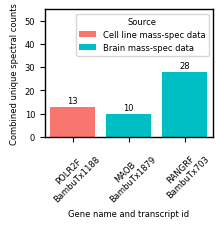

In [31]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 1)

ax = sns.barplot(data=df_known_genes, y="combined_unique_spectral_count", x="ID",
                 hue="Source", palette=[ggplot2_colors[0], ggplot2_colors[4]], saturation=1, dodge=False)

plt.xticks(rotation=45)

plt.ylabel("Combined unique spectral counts")
plt.xlabel("Gene name and transcript id")

ax.bar_label(ax.containers[0], fontsize=6, padding=1)
ax.bar_label(ax.containers[1], fontsize=6, padding=1)    

ax.set(ylim=(0, 55))

plt.savefig('../figures/known_gene_protein_validation.pdf', dpi=600, transparent=True, bbox_inches="tight")

plt.show()

In [36]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)

# figure size in millimiters
rcParams['figure.figsize'] = (55*mm, 40*mm)
rcParams.update({'font.size': 6})
rcParams['axes.linewidth'] = 1

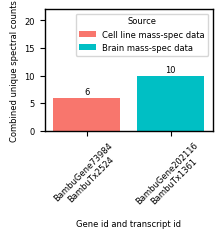

In [37]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 1)

ax = sns.barplot(data=df_new_genes, y="combined_unique_spectral_count", x="ID",
                 hue="Source", palette=[ggplot2_colors[0], ggplot2_colors[4]], saturation=1, dodge=False)

plt.xticks(rotation=45)

plt.ylabel("Combined unique spectral counts")
plt.xlabel("Gene id and transcript id")

ax.bar_label(ax.containers[0], fontsize=6, padding=1)
ax.bar_label(ax.containers[1], fontsize=6, padding=1)    

ax.set(ylim=(0, 22))

plt.savefig('../figures/new_gene_protein_validation.pdf', dpi=600, transparent=True, bbox_inches="tight")

plt.show()